# Reflexion Agent

In [2]:
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
import datetime 
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
# from schema import AnswerQuestion, ReviseAnswer
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.messages import HumanMessage

load_dotenv()

True

### Declare the schema

In [3]:
from typing import  List
from pydantic import BaseModel, Field

class Reflection(BaseModel):
     missing: str = Field(description="Critique of what is missing.")
     superfluous: str = Field(description="Critique of what is superfluous.")

class AnswerQuestion(BaseModel):
     """ Answer to the Question"""

     answer: str = Field(description="~250 word detailed answer to the question")
     search_queries: List[str] = Field(description="1-3 search queries for researching improvements to address the critique of your current answer")
     reflect: Reflection = Field(description="Your refelcton on the initial answer")

class ReviseAnswer(AnswerQuestion):
     """Revise your original answer to your question."""
     references: List[str] = Field(description="Citations motivating your update answer.")

### Actor Agent Prompt
use .prtial to prefill the {time} variable, the {first_instruction} and {messages} will be filled in later

In [32]:
#Actor Agent Prompt
actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system",
         """ You are expert AI Researcher
         Current Time: {time}
         
         1. {first_instruction}
         2. Reflect and critique your answer. Be severe to maximize improvement.
         3. After the reflectiom, **List 1-3 search queires seperately** for researching improvements.
         Do not include them inside the reflection
         """),
         MessagesPlaceholder(variable_name="messages"),
         ("system",
          "Answer the user's question above using thre required format.")
    ]
).partial(  # .partials is used to prepopulate prompt template before invoking it on LLM
    time=lambda: datetime.datetime.now().isoformat()
)

first_responder_prompt_template = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250word answer"
)

#### Doing the code below can also help show the result of actor_prompt_template with all the content filled in
- it fills in the {first_instruction} and the messages
  
> ```python
from IPython.display import display, Markdown
formatted_prompt = actor_prompt_template.format(
    first_instruction="Define the difference between AGI and LLMs.",
    messages=[
        {"role": "user", "content": "What is the difference between AGI and LLMs?"}
    ]
)
display(Markdown(formatted_prompt))
```

### create 1st chain for called first_responder_chain

In [40]:
tools=[AnswerQuestion]
llm = ChatOpenAI(model="gpt-4o")

first_responder_chain = first_responder_prompt_template | llm.bind_tools(tools=tools,tool_choice='AnswerQuestion')

pydantic_validator= PydanticToolsParser(tools=tools)
#you can pass it through the pydantic_validator if you want to do validation on your response.
# it will however not respond with the appropriate format as an AIMessage
# first_responder_parsed  = first_responder_prompt_template | llm.bind_tools(tools=tools,tool_choice='AnswerQuestion') |pydantic_validator


#### Create 2nd chain -  revisor_chain. Use  revise_instructions to replace {first_instruction} then send the output to the llm with binding to ReviseAnswer Tool

In [38]:
#revisor section - This section is activate after the initial prompt (responder) as generated its response
# response of the responder will be the input for the revisor. i.e. The revisor revised the original (responder) response
revise_instructions = """
Revise your  previous answer using the new information
- You should use the revious critique to add important information to your answer.
- You MUST inlude numerical citations in your revised answer to ensure it can ver verified
- add a "References" section to the botton of your anwser (which does not count towards the word limit). 
in form of:
    - [1] https://example.com
    - [2] https://example.com
- You should use the previous critique to remove superfluous information from your answer and make SURE it is not more th
250 words.
"""

# add the actor template and the revisor template together
revisor_chain = actor_prompt_template.partial(
    first_instruction = revise_instructions
) | llm.bind_tools(tools=[ReviseAnswer], tool_choice='ReviseAnswer')


### create execute_tools node 

In [41]:

import json
from typing import List, Dict, Any 
from langchain_core.messages import AIMessage, BaseMessage, ToolMessage, HumanMessage
from langchain_community.tools import TavilySearchResults
# create the Tavily Search tool
tavily_tools = TavilySearchResults(max_results=3)



def execute_tools(state:List[BaseMessage]) ->List[BaseMessage]:
    #from the list of message, get the last message (which is usally an AIMessage tool message)
    last_ai_message = state[-1] 

    #extract tool calls from the AI Message
    # start by checking if the last ai message is a tool call, if not return []
    if not hasattr(last_ai_message,"tool_calls") or not last_ai_message.tool_calls:
        return []
    
    tool_messages = [] #this will store all the tools
    # if last_ai_message is a tool then loop through all the available tools
    for tool_call in last_ai_message.tool_calls:
        if tool_call["name"] in ["AnswerQuestion", "ReviseAnswer"]: # is there a tool called AnswerQuestion or ReviseAnswer
            call_id = tool_call["id"] #if you found any of then the get their id
            search_queries = tool_call["args"].get("search_queries", []) # also get the search_queries list data inside args dict

            #loop through the list in search_queries and store the result in query_results
            #each search_queries item contain a query string. This will be passed to tavily to generate respond
            query_results = {}
            for query in search_queries:
                result = tavily_tools.invoke(query) # this uses tavily tool to generate a list of 3 response for each query in search_queries
                query_results[query]= result # store the response in the query_results dictionary

            #create a tool with the generated result
            tool_messages.append(
                ToolMessage(
                    content = json.dumps(query_results),
                    tool_call_id = call_id,
                )
            )
    return state + tool_messages

### Create Graph

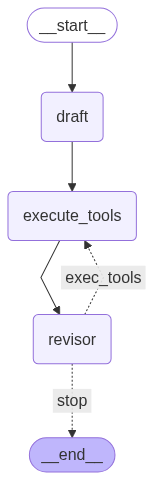

In [44]:
from typing import List
from langchain_core.messages import BaseMessage, ToolMessage
from langgraph.graph import END, MessageGraph

MAX_ITERATION = 2

graph = MessageGraph()

graph.add_node("draft", first_responder_chain)
graph.add_node("execute_tools", execute_tools)
graph.add_node("revisor", revisor_chain)


graph.set_entry_point("draft") # from start node, add the draft node
graph.add_edge("draft", "execute_tools") # from draft node, add the execute tool node
graph.add_edge("execute_tools", "revisor")# from execute node add revisor node

def event_loop(state: List[BaseMessage])->str:
    # check the number of tools are in the state message.
    #this is to capture how many times the tool is called
    count_tool_visits = sum(isinstance(item, ToolMessage) for item in state)
    num_iterations = count_tool_visits

    #if the counted tool call is greater than the maximum allowed then end the program
    # if not, call the tool again.
    if num_iterations > MAX_ITERATION:
        return "stop"
    return "exec_tools"

# from revisor node add tools node and let tools node decide either to goto END node or loop back to revisor node
graph.add_conditional_edges("revisor", event_loop,{"exec_tools":"execute_tools","stop":END }) 

app = graph.compile()

app

In [45]:
response =app.invoke("Write about how small businesses can leverage AI to grow")

answers = response[-1].tool_calls[0]["args"]["answer"]
print(answers)

print("RESPONSE:\n", response)

AttributeError: 'list' object has no attribute 'tool_calls'

In [57]:
from IPython.display import display, Markdown
final_message = response[-1].tool_calls[0]["args"]["answer"]
display(Markdown(final_message))

AI offers small businesses an unprecedented opportunity to enhance growth and remain competitive. Personalized marketing can be revolutionized by AI algorithms that analyze customer data, tailoring campaigns to increase engagement and conversion rates. Notably, tools like predictive analytics can anticipate customer behavior, facilitating strategic decisions [1]. 

Implementing AI-driven chatbots can significantly elevate customer service by offering 24/7 support for common inquiries, thereby improving customer interaction while freeing up personnel for strategic initiatives [1]. Moreover, routine administrative tasks such as scheduling and data entry can be efficiently automated, allowing teams to focus on strategic planning rather than mundane tasks.

AI also streamlines operations in inventory management, helping maintain optimal stock levels, thereby minimizing costs and stockouts. Sentiment analysis tools further provide insights into brand perception from social media and customer feedback, enabling strategic refinements [2].

Despite these benefits, challenges including high implementation costs and complexity must be addressed. Small businesses can overcome these challenges by seeking streamlined solutions or partnerships for AI integration [3]. Additionally, ethical considerations such as data privacy need attention to ensure responsible AI deployment [3].

References
- [1] https://www.forbes.com
- [2] https://www.uschamber.com
- [3] https://www.weforum.org

NameError: name 'response' is not defined